In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata
from datetime import datetime
from scipy import stats
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from scipy.stats import variation

# Changing rate of infection each year

##### PLAN

At end of each year - change beta eg $\beta \in \beta_0 [1,0.7, 0.5, 0.3]$

Run model multiple times and find variance for every time step

In [ ]:
print(120-365)
np.array([365*i-245 for i in range(1, int(round(capT/365))+1)]) - np.array([365*i for i in range(int(round(capT/365)))])

In [ ]:
def gillespieSEIR_season_exposure(initial, dist, dim, beta, mu1,mu2, sigma,epsilon,births, mu,  max_time):
    event_time = []
#     initial = [1500-exposed, exposed, 1, 0]
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    years = 1
    year = 1
    count = 1
    cuminf = []
    cuminf.append(0)
    events = []
    event_years = []
    k = 0
    l = 0
    ends = [365*i-245 for i in range(1, int(round(max_time/365))+1)]
    starts = [365*i for i in range(int(round(max_time/365)))]
#     print(ends[-1])
    infected_individuals_years = []
    total_years = []
    variance_years = []
    cov_years = []
    condi = [0]
    while times <max_time:
#         print(years, times)
        
        state = np.zeros(shape= (4,12))
        
        ############################### Seasonality #######################################
#         if np.round(times)%365 <= 120:
#             E = epsilon
#         else:
#             E = 0
        print(times,years)
        minicondi = 5
#         print(ends[k], starts[l])
        if k<55:
            if (times > ends[k]) and (condi[-1] == 1):
                print('end', years)
                times = ends[k]
                E = 0
                k = k+1
                minicondi =0
        if l<54:
            if (times >= starts[l]) and (condi[-1] == 0):
                print('start', years)
                times = starts[l]
                E = epsilon
                l= l+1
                minicondi = 1
                                         
        if minicondi == 0 or minicondi ==1:
            condi.append(minicondi)
        print(condi[-1])
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################    
        
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N + E*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0]

        R_ir = mu2*pop[ind][2]
        state[:,2] = [0,0,-1,1]
        

        R_is = mu1*pop[ind][2]
        state[:,3] = [1,0,-1,0]

        
        R_ed = mu*pop[ind][1]
        state[:,4] = [1,-1,0,0]
        
        R_id = mu*pop[ind][2]
        state[:,5] = [1, 0, -1, 0]
        
    
        R_sb =mu*pop[ind][3]
        state[:,6] = [1,0,0,-1]

        if (math.ceil(times/365) > years):
            
            variance_years.append(np.var(infected_individuals_years))
            
#             print(variance_years)
            total_years.append(sum(k==1 for k in event_years))
            if sum(k <4 for k in event_years)==0:
                count +=1
                cov_years.append(0)
            else:
                cov_years.append(variation(infected_individuals_years))
#             print(years)
            years = math.ceil(times/365)
            event_years = []
            infected_individuals_years = []
########################## RATES ##############################
        rate = [R_se, R_ei,  R_ir,  R_is, R_ed, R_id, R_sb]

        Rtotal = sum(rate)
        
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        
        
        if Rtotal>0:
            event = np.min(np.where(P<=np.cumsum(rate)))
            event_years.append(event)

            if event == 1 and count == years:
#                 print(years)
                rand_E = np.random.randint(0,dim-1)
                ex = dist[rand_E]
                state = [-ex, ex, 1, 0]
                infected_individuals_years.append((pop[ind]+state)[2])
#                 print(infected_individuals_years, years, times)
                pop.append(pop[ind]+state)
                count +=1
                times =times+ delta_t
                events.append(event)
                event_time.append(times)
                
            else:
#                 print(event, count, years)
                infected_individuals_years.append((pop[ind]+state[:,event])[2])
#                 print(infected_individuals_years, years, times)
                times =times+ delta_t
                events.append(event)
                event_time.append(times)
                pop.append(pop[ind]+state[:,event])
        else:
            print('here')
            times = year*365
            year = year +1 
            events.append(-1)
            event_time.append(times)
            pop.append(pop[ind])
        if event == 1:
            cuminf.append(1 +cuminf[ind] )
        else:
            cuminf.append(0 +cuminf[ind])
        ind=ind+1
#         N = sum(pop[ind][:5])

    return event_time, np.array(pop), events, cuminf, total_years, variance_years, cov_years


In [ ]:
def gillsteps(G):
    t = G[0]
    s = G[1][:,0]
    e = G[1][:,1]
    i = G[1][:,2]
    r = G[1][:,3]
    cum = G[3]
    stept = []
    steps = []
    stepi = []
    stepe = []
    stepr = []
    cuminf = []
    for ind, x in enumerate(t):
        if ind<len(t)-1:
            steps.append((s[ind], s[ind]))
            stepi.append((i[ind], i[ind]))
            stepe.append((e[ind], e[ind]))
            stepr.append((r[ind], r[ind]))
            cuminf.append((cum[ind], cum[ind]))
            stept.append((t[ind], t[ind+1]))
        else:
            steps.append((s[ind], s[ind]))
            stepi.append((i[ind], i[ind]))
            stepe.append((e[ind], e[ind]))
            stepr.append((r[ind], r[ind]))
            cuminf.append((cum[ind], cum[ind]))
            stept.append((t[ind], t[ind]))
    steps = np.array(steps).flatten()
    stepi = np.array(stepi).flatten()
    stept = np.array(stept).flatten()
    stepe = np.array(stepe).flatten()
    stepr = np.array(stepr).flatten()
    cuminf = np.array(cuminf).flatten()
    return stept, steps, stepe, stepi, stepr, cuminf

In [3]:
θ_new = np.load('../ABC/ABC_season/theta_new_F04_prior.npy')#ɛ>0
maxtol_new = len(θ_new)-1
dim_new = len(θ_new[0])
a_β, loc_β, scale_β = stats.gamma.fit(θ_new[maxtol_new][:,0])
a_ϵ, loc_ϵ, scale_ϵ = stats.gamma.fit(θ_new[maxtol_new][:,1])
a_σ, loc_σ, scale_σ = stats.gamma.fit([1/a for a in θ_new[maxtol_new][:,2]])
a_μ1, loc_μ1, scale_μ1 = stats.gamma.fit([1/a for a in θ_new[maxtol_new][:,3]])
a_μ2, loc_μ2, scale_μ2 = stats.gamma.fit([1/a for a in θ_new[maxtol_new][:,4]])

β = stats.gamma.rvs( a_β, loc_β, scale_β)
μ1 = 1/stats.gamma.rvs( a_μ1, loc_μ1, scale_μ1)
μ2 = 1/stats.gamma.rvs( a_μ2, loc_μ2, scale_μ2)
σ = 1/stats.gamma.rvs( a_σ, loc_σ, scale_σ)
ϵ = stats.gamma.rvs( a_ϵ, loc_ϵ, scale_ϵ)

random_E = np.random.randint(0,dim_new-1)
exposed = θ_new[maxtol_new][:,5][random_E]
birth = 1/(67*365)
μ = 1/(67*365)

In [4]:
capT = 20000
M = gillespieSEIR_season_exposure([1500,0,0,0],θ_new[maxtol_new][:,5], dim_new, β, μ1,μ2, σ,ϵ,birth, μ,  capT)
S = gillsteps(M)
M[5]
M[6]
plt.plot(range(54), M[5], label = 'variation')
plt.plot(range(54), M[6], label = 'coeficient of variation')
plt.legend()

# len(M[6])
# S[]

NameError: name 'gillespieSEIR_season_exposure' is not defined

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(S[0], S[3])
plt.xticks([365*i for i in range(int(round(capT/365)))], ["{}".format(i) for i in range(int(round(capT/365)))]);
# plt.xlim([365*38, 365*40])

In [ ]:
print('Number of infections each year', M[4])
len(M[4])

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(S[0], S[2],c='orange', label = 'exposed')

plt.plot(S[0],S[3],c= 'r', label = 'infected')
plt.legend(fontsize = 20)
# plt.plot(S[0], S[4])
# plt.ylim([0,30])
# 
plt.xticks([365*i for i in range(int(round(capT/365)))], ["{}".format(i) for i in range(int(round(capT/365)))]);

# plt.xlim([0,300])

In [ ]:
def reducinginfections(initial, dist_ex, dim, p, beta, mu1,mu2, sigma,epsilon,births, mu,  max_time):
    event_time = []
#     initial = [1500-exposed, exposed, 1, 0]
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    years = 1
    year = 1
    count = 1
    cuminf = []
    cuminf.append(0)
    events = []
    event_years = []
    k = 0
    l = 0
    ends = [365*i-245 for i in range(1, int(round(max_time/365))+1)]
    starts = [365*i for i in range(int(round(max_time/365)))]
#     print(ends[-1])
    infected_individuals_years = []
    total_years = []
    variance_years = []
    cov_years = []
    mean_years = []
    condi = [0]
    while times <max_time:
         
        state = np.zeros(shape= (4,12))
        
        ############################### Seasonality #######################################
#         if np.round(times)%365 <= 120:
#             E = epsilon
#         else:
#             E = 0
#         print(times,years)
        minicondi = 5
#         print(ends[k], starts[l])
        if k<(len(ends)-1):
            if (times > ends[k]) and (condi[-1] == 1):
#                 print('end', years)
                times = ends[k]
                E = 0
                k = k+1
                minicondi =0
        if l<(len(starts)-1):
            if (times >= starts[l]) and (condi[-1] == 0):
#                 print('start', years)
                times = starts[l]
                E = epsilon*(1-p*years)
                l= l+1
                minicondi = 1
                                         
        if minicondi == 0 or minicondi ==1:
            condi.append(minicondi)
#         print(condi[-1])
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################    
        
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N + E*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0]

        R_ir = mu2*pop[ind][2]
        state[:,2] = [0,0,-1,1]
        

        R_is = mu1*pop[ind][2]
        state[:,3] = [1,0,-1,0]

        
        R_ed = mu*pop[ind][1]
        state[:,4] = [1,-1,0,0]
        
        R_id = mu*pop[ind][2]
        state[:,5] = [1, 0, -1, 0]
        
    
        R_sb =mu*pop[ind][3]
        state[:,6] = [1,0,0,-1]

        if (math.ceil(times/365) > years):
#             print(infected_individuals_years)
            variance_years.append(np.var(infected_individuals_years/N))
            mean_years.append(np.mean(infected_individuals_years/N))
#             print(variance_years)
            total_years.append(sum(k==1 for k in event_years))
            if sum(k <4 for k in event_years)==0:
                count +=1
                cov_years.append(np.nan)
            else:
                cov_years.append(variation(infected_individuals_years/N))
#             print(years)
            years = math.ceil(times/365)
            event_years = []
            infected_individuals_years = []
########################## RATES ##############################
        rate = [R_se, R_ei,  R_ir,  R_is, R_ed, R_id,R_sb]

        Rtotal = sum(rate)
        
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        
        if Rtotal>0:
            event = np.min(np.where(P<=np.cumsum(rate)))
            event_years.append(event)
#             print( years,count, times, event)
    
            if event == 1 and count == years:
#                 print(years)
                rand_E = np.random.randint(0,dim-1)
                ex = dist_ex[rand_E]
#                 ex = np.maximum(math.floor(dist_ex[rand_E]*(1-p*years)),0)
#                 print(ex)
                state2 = [-ex-1, ex, 1, 0]
                infected_individuals_years.append((pop[ind]+state2)[2])
                pop.append(pop[ind]+state2)
                count +=1
                times =times+ delta_t
                events.append(event)
                event_time.append(times)
                
            else:
#                 print(event, count, years)
                infected_individuals_years.append((pop[ind]+state[:,event])[2])
                times =times+ delta_t
                events.append(event)
                event_time.append(times)
                pop.append(pop[ind]+state[:,event])
        else:
#             print('here')
            times = year*365
            year = year +1 
            events.append(-1)
            event_time.append(times)
            pop.append(pop[ind])
        if event == 1:
            cuminf.append(1 +cuminf[ind] )
        else:
            cuminf.append(0 +cuminf[ind])
        ind=ind+1
        N = sum(pop[ind][:5])

    return event_time, np.array(pop), events, cuminf, total_years, variance_years, cov_years, mean_years


In [ ]:
RedM = reducinginfections([1500,0,0,0],θ_new[maxtol_new][:,5], dim_new,1/50, β, μ1,μ2, σ,ϵ,birth, μ,  50*365)
RedS = gillsteps(RedM)
print('Number of infections each year', RedM[4])

# RedM[5]
# print(RedM[4][14])
capT
# ((RedM[6]))


In [ ]:
plt.subplot(1,2,1)
plt.plot(range(49), RedM[5], label = 'variation')
plt.subplot(1,2,2)
plt.plot(range(49), RedM[6], label = 'coeficient of variation')
plt.legend()

In [ ]:
capT = 20000
RedS[0][-1]/365

RedM[7]

In [ ]:
plt.figure(figsize = (20,8))
# plt.plot(RedS[0], RedS[2],c='orange', label = 'exposed')

plt.plot(range(49),[a*N for a in RedM[7]],c= 'r', label = 'infected')
plt.legend(fontsize = 20)
plt.plot(range(50), [b*N for b in m])
# plt.plot(S[0], S[4])
# plt.ylim([0,30])
# 
# plt.xticks([365*i for i in range(50)], ["{}".format(i) for i in range(50)]);

# plt.xlim([5.2*365,5.5*365])

In [ ]:
inter_t = np.arange(0, round(max(RedS[0])) +1 , 1) #interpolate to daily steps
inter_inf = np.interp(inter_t, RedS[0],RedS[3])
50*365

In [ ]:
SIM = 300
Y = 500
p = 1/Y
capT = Y*365
# simulations = np.zeros(shape=(SIM, capT))
variances = np.zeros(shape = (SIM, Y))
covs = np.zeros(shape = (SIM, Y))
means = np.zeros(shape=(SIM, Y))

for k in range(SIM):
    print(k)
    G = reducinginfections([1500,0,0,0],θ_new[maxtol_new][:,5], dim_new,p, β, μ1,μ2, σ,ϵ,birth, μ,  capT)
    if len(G[5])<Y:
        variances[k,:] = np.concatenate([G[5],np.zeros(Y - len(G[5]))])
        covs[k,:] = np.concatenate([G[6],np.full(Y - len(G[6]), np.nan)])
        means[k,:] = np.concatenate([G[7], np.zeros(Y-len(G[7]))])
    else:
        variances[k,:] =  G[5][:Y]
        covs[k,:] = G[6][:Y]
        means[k,:] = G[7][:Y]

In [ ]:
20000/365

In [ ]:
np.mean(variances, axis = 0)
variances[0:k,:]
stats.mode([np.nan, np.nan, np.nan])

# Quasi-stationary

In [ ]:
def Qc(Bb, Ee):
    if Ee == 0:
        s = ((σ + μ)*(μ+μ1+μ2)/(σ*Bb))
        i = (μ*(1-s))/(Bb*s - μ1)
        e = i*(μ1+μ2+μ)/σ
        
    else:
        A = -(Bb/σ)*(σ+μ)*(μ+μ1+μ2)+μ1*Bb
        B = (Ee*μ1+μ*Bb - (σ + μ)*(μ+μ1+μ2)*((μ+Ee)/σ))
        C = μ*Ee
#         i = 0
    #     print((-B+np.sqrt(B**2-4*A*C))/(2*A),(-B-np.sqrt(B**2-4*A*C))/(2*A) )
        if (-B-np.sqrt(B**2 - 4*A*C))/(2*A) >=0:
#             print('yes')
            i = (-B-np.sqrt(B**2 - 4*A*C))/(2*A)
        if (-B+np.sqrt(B**2 - 4*A*C))/(2*A) >= 0:
#             print('no')
            i = (-B+np.sqrt(B**2 - 4*A*C))/(2*A)

        s = (((σ+μ)/σ)*(μ1+μ2+μ)*i)/(Bb*i + Ee)
        e = (i/σ)*(μ1 + μ2 + μ)
    
    return [s, e, i]

In [ ]:
Y

In [ ]:
def integrand(x, a0,a1,a2, deta, ta, tc):
    return (a0 +a1*(x**2) + a2*(x**4))/((deta-(x**2)*ta)**2 + (x**2)*((tc+(x**2))**2))
from scipy.integrate import quad

In [ ]:
quasi = []
quasi2 = []
quasi_cov = []
Q = []
m = []
N = 1500
for k in range(Y):
#     b = β*(1-p*k)
#     b = β*(1-p*k)
    b = β
    eps = ϵ*(1-p*k)
    #####fixed points #####

    [star0, star1, star2] = Qc(b, eps)
    print(star2)
    m.append(star2)
    ##### matrices A and B ######
    A= np.matrix([[-b*star2-eps - μ, 0, μ1 - b*star0], 
                  [b*star2 + eps, -μ-σ*star1, b*star0], 
                  [0, σ*star1, -μ-μ1-μ2]])
    B = np.matrix([[b*star2*star0 + eps*star0+μ*(1-star0) + μ1*star2, -(b*star0*star2 +eps*star0+μ*star1), -(μ +μ1)*star2]
                   ,[-(b*star0*star2 +eps*star0+μ*star1), b*star0*star2+μ*star1+eps*star0+σ*star1, -σ*star1],
                  [-(μ+μ1)*star2, σ*star1, star2*(μ+μ1+μ2)+σ*star1]])
    det = np.linalg.det(A)
    C= np.linalg.inv(A)*(det*np.identity(3))
#     alph = (A[1,0]**2)*B[0,0] -2*A[0,0]*A[1,0]*B[1,0] +(A[0,0]**2)*B[1,1]
    alpha0 = (B[0,0]*(C[2,0]**2)+B[1,1]*(C[2,1]**2) + B[2,2]*(C[2,2]**2)+
            2*(C[2,0]*C[2,1]*B[0,1] + C[2,0]*C[2,2]*B[0,2] + C[2,1]*C[2,2]*B[1,2]))
    alpha1 = ((A[2,0]**2)*B[0,0] + 2*A[2,0]*A[2,1]*B[0,1] - 2*(C[2,0] + (A[0,0]+A[1,1])*A[2,0])*B[0,2] +
             (A[2,1]**2)*B[1,1] - 2*(C[2,1] +A[2,1]*(A[0,0] + A[1,1]))*B[1,2] +
             ((A[0,0] + A[1,1])**2 -2*C[2,2])*B[2,2])
    alpha2 = B[2,2]
#     det = np.linalg.det(A)
    tra = np.trace(A)
    trc = np.trace(C)
    ######### Integration #########
#     print(star0)
    S = (1/(2*np.pi))*quad(integrand, -np.inf, np.inf, args=(alpha0, alpha1, alpha2, det, tra, trc))[0]
#     print((1/(2*np.pi))*quad(integrand, -np.inf, np.inf, args=(alpha0, alpha1, alpha2, det, tra, trc))[1])
    quasi.append(S/N)
    quasi_cov.append(np.sqrt(S/N)/star2)

In [ ]:
fig = plt.figure(figsize = (20,8))
# plt.subplot(1,2,1)
ax = fig.add_subplot(121)

plt.plot(range(Y), np.nanmedian(variances, axis = 0), label = 'var')
plt.plot(range(Y), np.maximum(quasi, 0), c= 'green')
plt.xlabel('years', fontsize = 20)
ax.annotate('Predicted $t* = 445 $ for \n $R_0 = 1$', xy=(445, 0), xytext=( 300,0.6e-7),
            arrowprops=dict(facecolor='grey', shrink=0.05), fontsize = 14
            )
plt.xlabel('ɛ (t) = ɛ(1-p*year)', fontsize = 20)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tight_layout()
# plt.legend(fontsize = 16)
ax2 = fig.add_subplot(122)
# plt.plot(range(Y), quasi_cov, c = 'green')
plt.plot(range(Y), np.nanmedian(covs, axis = 0), label = 'cv')
plt.xlabel('years', fontsize = 20)
ax2.annotate('Predicted $t*$ for \n $R_0 = 1$', xy=( 445, 1.6), xytext=( 300, 1.4),
            arrowprops=dict(facecolor='grey', shrink=0.05), fontsize = 14
            )
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tight_layout()
# plt.xlim([0,50])
# plt.legend(fontsize = 16)

In [5]:
def format_e(n):
    a = '%2E' % n
#     print(round(float(a.split('E')[0]),2))
    b = str(round(float(a.split('E')[0]),2))
    return b.rstrip('0').rstrip('.') + 'e' + a.split('E')[1]
import decimal

In [6]:
format_e(ϵ)

'3e-05'

In [ ]:
fig = plt.figure(figsize = (20,8))
# plt.subplot(1,2,1)
ax = fig.add_subplot(121)

plt.plot(range(Y), np.nanmedian(variances, axis = 0), label = 'var')
# plt.plot(range(Y), np.maximum(quasi, 0), c= 'green')
# plt.xlabel('years', fontsize = 20)

plt.xlabel('$ɛ (t) = ɛ_0 (1-p*year)$', fontsize = 20)
plt.xticks([100*i for i in range(6)], ["{}".format(format_e(ϵ*(1-p*100*i))) for i in range(6)])
# plt.xticks([10*i for i in range(50)], ["{}".format(\beta*(1-p*10*i) for i in range(50))])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tight_layout()
# plt.legend(fontsize = 16)
ax2 = fig.add_subplot(122)
# plt.plot(range(Y), quasi_cov, c = 'green')
plt.plot(range(Y), np.nanmedian(covs, axis = 0), label = 'cv')
plt.xlabel('years', fontsize = 20)
plt.xlabel('$ɛ (t) = ɛ_0 (1-p*year)$', fontsize = 20)
plt.xticks([100*i for i in range(6)], ["{}".format(format_e(ϵ*(1-p*100*i))) for i in range(6)])

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tight_layout()

In [ ]:
# stats.mode(covs, axis = 0, nan_policy='omit')[0][0]
# covs[:,48]
plt.plot(range(Y), np.median(means, axis = 0))
plt.plot(range(Y), m)

In [ ]:
np.median(covs[:,49])

# Change it for $\beta(t) = \beta_0 (1-p*year)$

In [ ]:
def reducinginfectionsbeta(initial, dist_ex, dim, p, b, mu1,mu2, sigma,epsilon,births, mu,  max_time):
    event_time = []
#     initial = [1500-exposed, exposed, 1, 0]
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    years = 1
    year = 1
    count = 1
    cuminf = []
    cuminf.append(0)
    events = []
    event_years = []
    k = 0
    l = 0
    ends = [365*i-245 for i in range(1, int(round(max_time/365))+1)]
    starts = [365*i for i in range(int(round(max_time/365)))]
#     print(ends[-1])
    infected_individuals_years = []
    total_years = []
    variance_years = []
    cov_years = []
    mean_years = []
    condi = [0]
    while times <max_time:
         
        state = np.zeros(shape= (4,12))
        
        ############################### Seasonality #######################################
#         if np.round(times)%365 <= 120:
#             E = epsilon
#         else:
#             E = 0
#         print(times,years)
        minicondi = 5
#         print(ends[k], starts[l])
        if k<(len(ends)-1):
            if (times > ends[k]) and (condi[-1] == 1):
#                 print('end', years)
                times = ends[k]
                E = 0
                k = k+1
                minicondi =0
        if l<(len(starts)-1):
            if (times >= starts[l]) and (condi[-1] == 0):
#                 print('start', years)
                times = starts[l]
                E = epsilon
                l= l+1
                minicondi = 1
                                         
        if minicondi == 0 or minicondi ==1:
            condi.append(minicondi)
#         print(condi[-1])
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################    
        beta = b*(1-p*years)
#         print(beta, years)
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N + E*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0]

        R_ir = mu2*pop[ind][2]
        state[:,2] = [0,0,-1,1]
        

        R_is = mu1*pop[ind][2]
        state[:,3] = [1,0,-1,0]

        
        R_ed = mu*pop[ind][1]
        state[:,4] = [1,-1,0,0]
        
        R_id = mu*pop[ind][2]
        state[:,5] = [1, 0, -1, 0]
        
    
        R_sb =mu*pop[ind][3]
        state[:,6] = [1,0,0,-1]

        if (math.ceil(times/365) > years):
#             print(infected_individuals_years)
            variance_years.append(np.var(infected_individuals_years/N))
            mean_years.append(np.mean(infected_individuals_years/N))
#             print(variance_years)
            total_years.append(sum(k==1 for k in event_years))
            if sum(k <4 for k in event_years)==0:
                count +=1
                cov_years.append(np.nan)
            else:
                cov_years.append(variation(infected_individuals_years/N))
#             print(years)
            years = math.ceil(times/365)
            event_years = []
            infected_individuals_years = []
########################## RATES ##############################
        rate = [R_se, R_ei,  R_ir,  R_is, R_ed, R_id,R_sb]

        Rtotal = sum(rate)
        
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        
        if Rtotal>0:
            event = np.min(np.where(P<=np.cumsum(rate)))
            event_years.append(event)
#             print( years,count, times, event)
    
            if event == 1 and count == years:
#                 print(years)
                rand_E = np.random.randint(0,dim-1)
                ex = dist_ex[rand_E]
#                 ex = np.maximum(math.floor(dist_ex[rand_E]*(1-p*years)),0)
#                 print(ex)
                state2 = [-ex-1, ex, 1, 0]
                infected_individuals_years.append((pop[ind]+state2)[2])
                pop.append(pop[ind]+state2)
                count +=1
                times =times+ delta_t
                events.append(event)
                event_time.append(times)
                
            else:
#                 print(event, count, years)
                infected_individuals_years.append((pop[ind]+state[:,event])[2])
                times =times+ delta_t
                events.append(event)
                event_time.append(times)
                pop.append(pop[ind]+state[:,event])
        else:
#             print('here')
            times = year*365
            year = year +1 
            events.append(-1)
            event_time.append(times)
            pop.append(pop[ind])
        if event == 1:
            cuminf.append(1 +cuminf[ind] )
        else:
            cuminf.append(0 +cuminf[ind])
        ind=ind+1
        N = sum(pop[ind][:5])

    return event_time, np.array(pop), events, cuminf, total_years, variance_years, cov_years, mean_years


In [ ]:
RedM = reducinginfectionsbeta([1500,0,0,0],θ_new[maxtol_new][:,5], dim_new,1/50, β, μ1,μ2, σ,ϵ,birth, μ,  50*365)
RedS = gillsteps(RedM)
print('Number of infections each year', RedM[4])

# RedM[5]
# print(RedM[4][14])
capT

In [ ]:
plt.subplot(1,2,1)
plt.plot(range(49), RedM[5], label = 'variation')
plt.subplot(1,2,2)
plt.plot(range(49), RedM[6], label = 'coeficient of variation')
plt.legend()

In [ ]:
SIM = 300
Y = 500
p = 1/Y
capT = Y*365
# simulations = np.zeros(shape=(SIM, capT))
variancesb = np.zeros(shape = (SIM, Y))
covsb = np.zeros(shape = (SIM, Y))
meansb = np.zeros(shape=(SIM, Y))

for k in range(SIM):
    print(k)
    G = reducinginfectionsbeta([1500,0,0,0],θ_new[maxtol_new][:,5], dim_new,p, β, μ1,μ2, σ,ϵ,birth, μ,  capT)
    if len(G[5])<Y:
        variancesb[k,:] = np.concatenate([G[5],np.zeros(Y - len(G[5]))])
        covsb[k,:] = np.concatenate([G[6],np.full(Y - len(G[6]), np.nan)])
        meansb[k,:] = np.concatenate([G[7], np.zeros(Y-len(G[7]))])
    else:
        variancesb[k,:] =  G[5][:Y]
        covsb[k,:] = G[6][:Y]
        meansb[k,:] = G[7][:Y]

In [ ]:
Y

In [ ]:
quasib = []
quasi_covb = []
mb= []
N = 1500
for k in range(Y):
#     b = β*(1-p*k)
    b = β*(1-p*k)
#     b = β
    eps = ϵ
    #####fixed points #####

    [star0, star1, star2] = Qc(b, eps)
    print(star2)
    mb.append(star2)
    ##### matrices A and B ######
    A= np.matrix([[-b*star2-eps - μ, 0, μ1 - b*star0], 
                  [b*star2 + eps, -μ-σ*star1, b*star0], 
                  [0, σ*star1, -μ-μ1-μ2]])
    B = np.matrix([[b*star2*star0 + eps*star0+μ*(1-star0) + μ1*star2, -(b*star0*star2 +eps*star0+μ*star1), -(μ +μ1)*star2]
                   ,[-(b*star0*star2 +eps*star0+μ*star1), b*star0*star2+μ*star1+eps*star0+σ*star1, -σ*star1],
                  [-(μ+μ1)*star2, σ*star1, star2*(μ+μ1+μ2)+σ*star1]])
    det = np.linalg.det(A)
    C= np.linalg.inv(A)*(det*np.identity(3))
#     alph = (A[1,0]**2)*B[0,0] -2*A[0,0]*A[1,0]*B[1,0] +(A[0,0]**2)*B[1,1]
    alpha0 = (B[0,0]*(C[2,0]**2)+B[1,1]*(C[2,1]**2) + B[2,2]*(C[2,2]**2)+
            2*(C[2,0]*C[2,1]*B[0,1] + C[2,0]*C[2,2]*B[0,2] + C[2,1]*C[2,2]*B[1,2]))
    alpha1 = ((A[2,0]**2)*B[0,0] + 2*A[2,0]*A[2,1]*B[0,1] - 2*(C[2,0] + (A[0,0]+A[1,1])*A[2,0])*B[0,2] +
             (A[2,1]**2)*B[1,1] - 2*(C[2,1] +A[2,1]*(A[0,0] + A[1,1]))*B[1,2] +
             ((A[0,0] + A[1,1])**2 -2*C[2,2])*B[2,2])
    alpha2 = B[2,2]
#     det = np.linalg.det(A)
    tra = np.trace(A)
    trc = np.trace(C)
    ######### Integration #########
#     print(star0)
    S = (1/(2*np.pi))*quad(integrand, -np.inf, np.inf, args=(alpha0, alpha1, alpha2, det, tra, trc))[0]
#     print((1/(2*np.pi))*quad(integrand, -np.inf, np.inf, args=(alpha0, alpha1, alpha2, det, tra, trc))[1])
    quasib.append(S/N)
    quasi_covb.append(np.sqrt(S/N)/star2)

In [ ]:
fig = plt.figure(figsize = (20,8))
# plt.subplot(1,2,1)
ax = fig.add_subplot(121)

plt.plot(range(Y), np.nanmedian(variancesb, axis = 0), label = 'var')
# plt.plot(range(Y), np.maximum(quasib, 0), c= 'green')
plt.xlabel('$β (t) = β_0 (1-p*year)$', fontsize = 20)
plt.xticks([100*i for i in range(6)], ["{}".format(round(β*(1-p*100*i),2)) for i in range(6)])
plt.plot(β, np.median(v), 'o')
# ax.annotate('Predicted $t*$ for \n $R_0 = 1$', xy=(430, 0.2e-7), xytext=( 400,0.6e-7),
#             arrowprops=dict(facecolor='grey', shrink=0.05), fontsize = 14
#             )
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tight_layout()
# plt.legend(fontsize = 16)
ax2 = fig.add_subplot(122)
# plt.plot(range(Y), quasi_covb, c = 'green')
plt.plot(range(Y), np.nanmedian(covsb, axis = 0), label = 'cv')
# plt.xlabel('years', fontsize = 20)
plt.xlabel('$β (t) = β_0 (1-p*year)$', fontsize = 20)
plt.xticks([100*i for i in range(6)], ["{}".format(round(β*(1-p*100*i),2)) for i in range(6)])# plt.xticks([10*i for i in range(50)], ["{}".format(\beta*(1-p*10*i) for i in range(50))])

# ax2.annotate('Predicted $t*$ for \n $R_0 = 1$', xy=( 430, 1.6), xytext=( 400, 1.6),
#             arrowprops=dict(facecolor='grey', shrink=0.05), fontsize = 14
#             )
plt.plot(β, np.median(c),'o')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tight_layout()

In [ ]:
plt.plot(range(Y), np.median(meansb, axis = 0))
plt.plot(range(Y), mb)

# Heat maps

In [29]:
p = 1/500
erange = [ϵ*(1-p*10*i)for i in range(60)]
brange = [β*(1-p*10*i)for i in range(60)]

In [30]:
cs = np.zeros(shape= (len(erange), len(brange)))
vs = np.zeros(shape= (len(erange), len(brange)))

for r in range(len(erange)):
    for n in range(len(brange)):
        print(n,r)
        v = []
        c = []
        for y in range(500):
            J = gillespieSEIR_season_exposed([1500,0,0,0],θ_new[maxtol_new][:,5], dim_new, brange[n], μ1,μ2, μ, σ, erange[r] )
            v.append(J[2])
            c.append(J[3])
        cs[r,n] = np.median(c)
        vs[r,n] = np.median(v)


0 0


/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars


1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1
22 1
23 1
24 1
25 1
26 1
27 1
28 1
29 1
30 1
31 1
32 1
33 1
34 1
35 1
36 1
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 1
47 1
48 1
49 1
50 1
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
10 2
11 2
12 2
13 2
14 2
15 2
16 2
17 2
18 2
19 2
20 2
21 2
22 2
23 2
24 2
25 2
26 2
27 2
28 2
29 2
30 2
31 2
32 2
33 2
34 2
35 2
36 2
37 2
38 2
39 2
40 2
41 2
42 2
43 2
44 2
45 2
46 2
47 2
48 2
49 2
50 2
51 2
52 2
53 2
54 2
55 2
56 2
57 2
58 2
59 2
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
10 3
11 3
12 3
13 3
14 3
15 3
16 3
17 3
18 3
19 3
20 3
21 3
22 3
23 3
24 3
25 3
26 3
27 3
28 3

/home/emma/.local/lib/python3.5/site-packages/scipy/stats/stats.py:998: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis) / a.mean(axis)
/home/emma/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


7 7
8 7
9 7
10 7
11 7
12 7
13 7
14 7
15 7
16 7
17 7
18 7
19 7
20 7
21 7
22 7
23 7
24 7
25 7
26 7
27 7
28 7
29 7
30 7
31 7
32 7
33 7
34 7
35 7
36 7
37 7
38 7
39 7
40 7
41 7
42 7
43 7
44 7
45 7
46 7
47 7
48 7
49 7
50 7
51 7
52 7
53 7
54 7
55 7
56 7
57 7
58 7
59 7
0 8
1 8
2 8
3 8
4 8
5 8
6 8
7 8
8 8
9 8
10 8
11 8
12 8
13 8
14 8
15 8
16 8
17 8
18 8
19 8
20 8
21 8
22 8
23 8
24 8
25 8
26 8
27 8
28 8
29 8
30 8
31 8
32 8
33 8
34 8
35 8
36 8
37 8
38 8
39 8
40 8
41 8
42 8
43 8
44 8
45 8
46 8
47 8
48 8
49 8
50 8
51 8
52 8
53 8
54 8
55 8
56 8
57 8
58 8
59 8
0 9
1 9
2 9
3 9
4 9
5 9
6 9
7 9
8 9
9 9
10 9
11 9
12 9
13 9
14 9
15 9
16 9
17 9
18 9
19 9
20 9
21 9
22 9
23 9
24 9
25 9
26 9
27 9
28 9
29 9
30 9
31 9
32 9
33 9
34 9
35 9
36 9
37 9
38 9
39 9
40 9
41 9
42 9
43 9
44 9
45 9
46 9
47 9
48 9
49 9
50 9
51 9
52 9
53 9
54 9
55 9
56 9
57 9
58 9
59 9
0 10
1 10
2 10
3 10
4 10
5 10
6 10
7 10
8 10
9 10
10 10
11 10
12 10
13 10
14 10
15 10
16 10
17 10
18 10
19 10
20 10
21 10
22 10
23 10
24 10
25 10
26 10
27 10


1 31
2 31
3 31
4 31
5 31
6 31
7 31
8 31
9 31
10 31
11 31
12 31
13 31
14 31
15 31
16 31
17 31
18 31
19 31
20 31
21 31
22 31
23 31
24 31
25 31
26 31
27 31
28 31
29 31
30 31
31 31
32 31
33 31
34 31
35 31
36 31
37 31
38 31
39 31
40 31
41 31
42 31
43 31
44 31
45 31
46 31
47 31
48 31
49 31
50 31
51 31
52 31
53 31
54 31
55 31
56 31
57 31
58 31
59 31
0 32
1 32
2 32
3 32
4 32
5 32
6 32
7 32
8 32
9 32
10 32
11 32
12 32
13 32
14 32
15 32
16 32
17 32
18 32
19 32
20 32
21 32
22 32
23 32
24 32
25 32
26 32
27 32
28 32
29 32
30 32
31 32
32 32
33 32
34 32
35 32
36 32
37 32
38 32
39 32
40 32
41 32
42 32
43 32
44 32
45 32
46 32
47 32
48 32
49 32
50 32
51 32
52 32
53 32
54 32
55 32
56 32
57 32
58 32
59 32
0 33
1 33
2 33
3 33
4 33
5 33
6 33
7 33
8 33
9 33
10 33
11 33
12 33
13 33
14 33
15 33
16 33
17 33
18 33
19 33
20 33
21 33
22 33
23 33
24 33
25 33
26 33
27 33
28 33
29 33
30 33
31 33
32 33
33 33
34 33
35 33
36 33
37 33
38 33
39 33
40 33
41 33
42 33
43 33
44 33
45 33
46 33
47 33
48 33
49 33
50 33
51 33
52 

27 54
28 54
29 54
30 54
31 54
32 54
33 54
34 54
35 54
36 54
37 54
38 54
39 54
40 54
41 54
42 54
43 54
44 54
45 54
46 54
47 54
48 54
49 54
50 54
51 54
52 54
53 54
54 54
55 54
56 54
57 54
58 54
59 54
0 55
1 55
2 55
3 55
4 55
5 55
6 55
7 55
8 55
9 55
10 55
11 55
12 55
13 55
14 55
15 55
16 55
17 55
18 55
19 55
20 55
21 55
22 55
23 55
24 55
25 55
26 55
27 55
28 55
29 55
30 55
31 55
32 55
33 55
34 55
35 55
36 55
37 55
38 55
39 55
40 55
41 55
42 55
43 55
44 55
45 55
46 55
47 55
48 55
49 55
50 55
51 55
52 55
53 55
54 55
55 55
56 55
57 55
58 55
59 55
0 56
1 56
2 56
3 56
4 56
5 56
6 56
7 56
8 56
9 56
10 56
11 56
12 56
13 56
14 56
15 56
16 56
17 56
18 56
19 56
20 56
21 56
22 56
23 56
24 56
25 56
26 56
27 56
28 56
29 56
30 56
31 56
32 56
33 56
34 56
35 56
36 56
37 56
38 56
39 56
40 56
41 56
42 56
43 56
44 56
45 56
46 56
47 56
48 56
49 56
50 56
51 56
52 56
53 56
54 56
55 56
56 56
57 56
58 56
59 56
0 57
1 57
2 57
3 57
4 57
5 57
6 57
7 57
8 57
9 57
10 57
11 57
12 57
13 57
14 57
15 57
16 57
17 57
18 5

In [38]:
np.save('coef_of_var', cs)
np.save('var', vs)

Text(771.227,0.5,'$ɛ(t) = ɛ_0 (1-p*year)$')

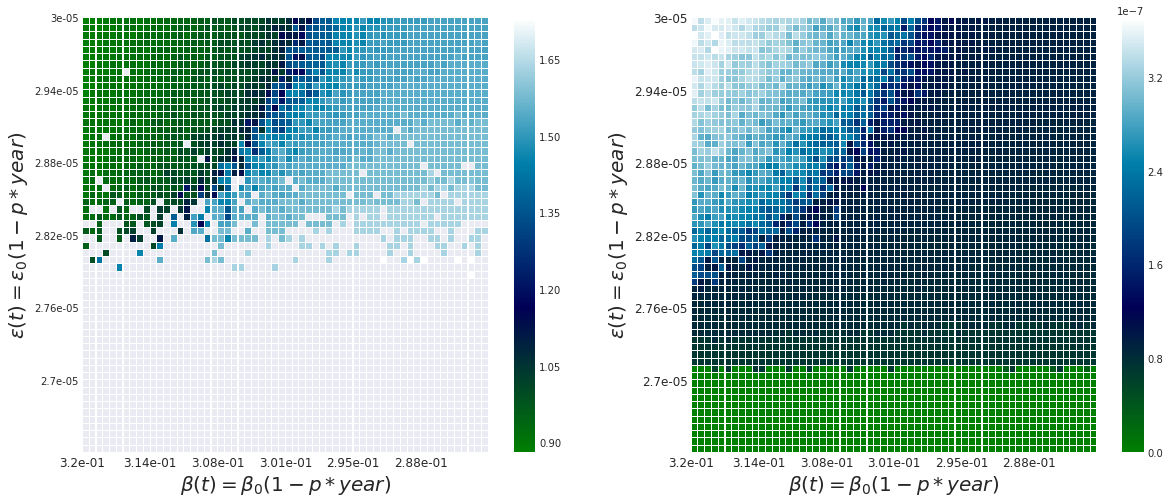

In [37]:
# sns.heatmap(vs, mask=np.isnan(vs))
plt.figure(figsize = (20,8))
sns.set_style(style='darkgrid', rc=None)
plt.subplot(1,2,1)
sns.heatmap(cs, cmap = 'ocean',mask = np.isnan(cs), linewidths=.1)
plt.xticks(np.arange(len(brange)),[round(a,2) for a in brange], fontsize = 12)
plt.xticks([10*i for i in range(6)], ["{}".format(format_e(β*(1-p*10*i))) for i in range(6)])
plt.yticks([10*i for i in range(6)], ["{}".format(format_e(ϵ*(1-p*10*i))) for i in range(6)], rotation = 0)

# plt.yticks(np.arange(len(erange)),[format_e(a) for a in  erange], rotation = 0, fontsize = 12)
plt.xlabel('$β(t) = β_0(1-p*year)$', fontsize = 20)
plt.ylabel('$ɛ(t) = ɛ_0 (1-p*year)$', fontsize = 20)

plt.subplot(1,2,2)
sns.heatmap(vs, cmap ='ocean', linewidth = 0.1,mask = np.isnan(vs))
plt.xticks(np.arange(len(brange)),[round(a,2) for a in brange], fontsize = 12)
plt.yticks(np.arange(len(erange)),[format_e(a) for a in  erange], rotation = 0, fontsize = 12)
plt.xticks([10*i for i in range(6)], ["{}".format(format_e(β*(1-p*10*i))) for i in range(6)])
plt.yticks([10*i for i in range(6)], ["{}".format(format_e(ϵ*(1-p*10*i))) for i in range(6)], rotation = 0)

plt.xlabel('$β(t) = β_0(1-p*year)$', fontsize = 20)
plt.ylabel('$ɛ(t) = ɛ_0 (1-p*year)$', fontsize = 20)

In [ ]:
mask = np.isnan(cs)
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
# cmap.set_under(".5")
# sns.heatmap(df, mask=mask)
# cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
# sns.heatmap(cs, cmap=cmap)
# pcm = sns.heatmap(cs,  cmap= 'ocean' , mask = mask) # you don't need rasterized=True
pcm.figure.axes[-1].yaxis.label.set_size(16)
plt.xticks(np.arange(6),[round(a,2) for a in brange])
plt.yticks(np.arange(6),[format_e(a) for a in  erange], rotation = 0)
plt.xlabel('β', fontsize = 16)
plt.ylabel('ɛ', fontsize = 16)

sns.heatmap(cs, cmap=cmap, mask=np.isnan(cs))

In [10]:
def gillespieSEIR_season_exposed(initial,dist_ex, dim,  b, mu1,mu2,mu, sigma,epsilon):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    year = 1
    cuminf = []
    cuminf.append(0)
    events = []
    count = 0
    Rtotal = 1
    death = 0
    while Rtotal>0:
        state = np.zeros(shape= (4,12))
        if (120 >=times >= 0):
            eps = epsilon
        if (365>times > 120):
#             times = 120
#             ind = ind -1
            eps = 0


        if (times>=365):
            print(times)
            break
        state = np.zeros(shape= (4,12))
        beta = b

        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################    
        
        R_external = eps*pop[ind][0]
        state[:,0] = [-1,1,0,0]
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N  
        state[:,1] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,2] = [0, -1, 1, 0]
        
        
        R_ir = mu2*pop[ind][2]
        state[:,3] = [0,0,-1,1]
        

        R_is = mu1*pop[ind][2]
        state[:,4] = [1,0,-1,0]
        
        R_ed = mu*pop[ind][1]
        state[:,5] = [1,-1,0,0]
        
        R_id = mu*pop[ind][2]
        state[:,6] = [1,0,-1,0]
        
        R_sb = mu*(pop[ind][3])
        state[:,7] = [1,0,0,-1]
        

########################## RATES ##############################
        rate = [R_external, R_se, R_ei,  R_ir,  R_is, R_ed, R_id, R_sb]

        Rtotal = sum(rate)

        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        
        
        
        if Rtotal>0:
            event = np.min(np.where(P<=np.cumsum(rate)))
    
            if event == 1 and count == 0:
                rand_E = np.random.randint(0,dim-1)
                ex = dist_ex[rand_E]
                state2 = [-ex-1, ex, 1, 0]
                pop.append(pop[ind]+state2)
                count +=1
                times =times+ delta_t
                events.append(event)
                event_time.append(times)
                
            else:
                times =times+ delta_t
                events.append(event)
                event_time.append(times)
                pop.append(pop[ind]+state[:,event])
            if event == 1:
                cuminf.append(1 +cuminf[ind] )
            else:
                cuminf.append(0 +cuminf[ind])
            ind = ind+1
        else:
            times = year*365
            year = year +1 
            events.append(-1)
            event_time.append(times)
            pop.append(pop[ind])
        

        if (times>=365):
            break
             
    var = np.var(np.array(pop)[:,2]/N)
    cov = variation(np.array(pop)[:,2]/N)
    return event_time, np.array(pop), var, cov

In [ ]:
# initial,dist_ex, dim,  b, mu1,mu2,mu, sigma,epsilon
J = gillespieSEIR_season_exposed([1500,0,0,0],θ_new[maxtol_new][:,5], dim_new, brange[0], μ1,μ2, μ, σ, erange[3] )

In [ ]:
v = []
c = []
for y in range(300):
    J = gillespieSEIR_season_exposed([1500,0,0,0],θ_new[maxtol_new][:,5], dim_new, β, μ1,μ2, μ, σ, ϵ )
    v.append(J[2])
    c.append(J[3])

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(J[0][:-1], J[1][:,2][:-1])
# plt.xlim([120,125])

In [ ]:
for 